In [1]:
import pandas as pd
import numpy as np

import json

from scripts.utils import SimulateData
from stopsignalmetrics.ssrtmodel import SSRTmodel

from IPython.display import Image
import matplotlib.pyplot as plt
import seaborn as sns

## Suffix
### Indicates which set of results to view

In [2]:
suffix = 'SSRTscale-5'

# SSRT by SSD

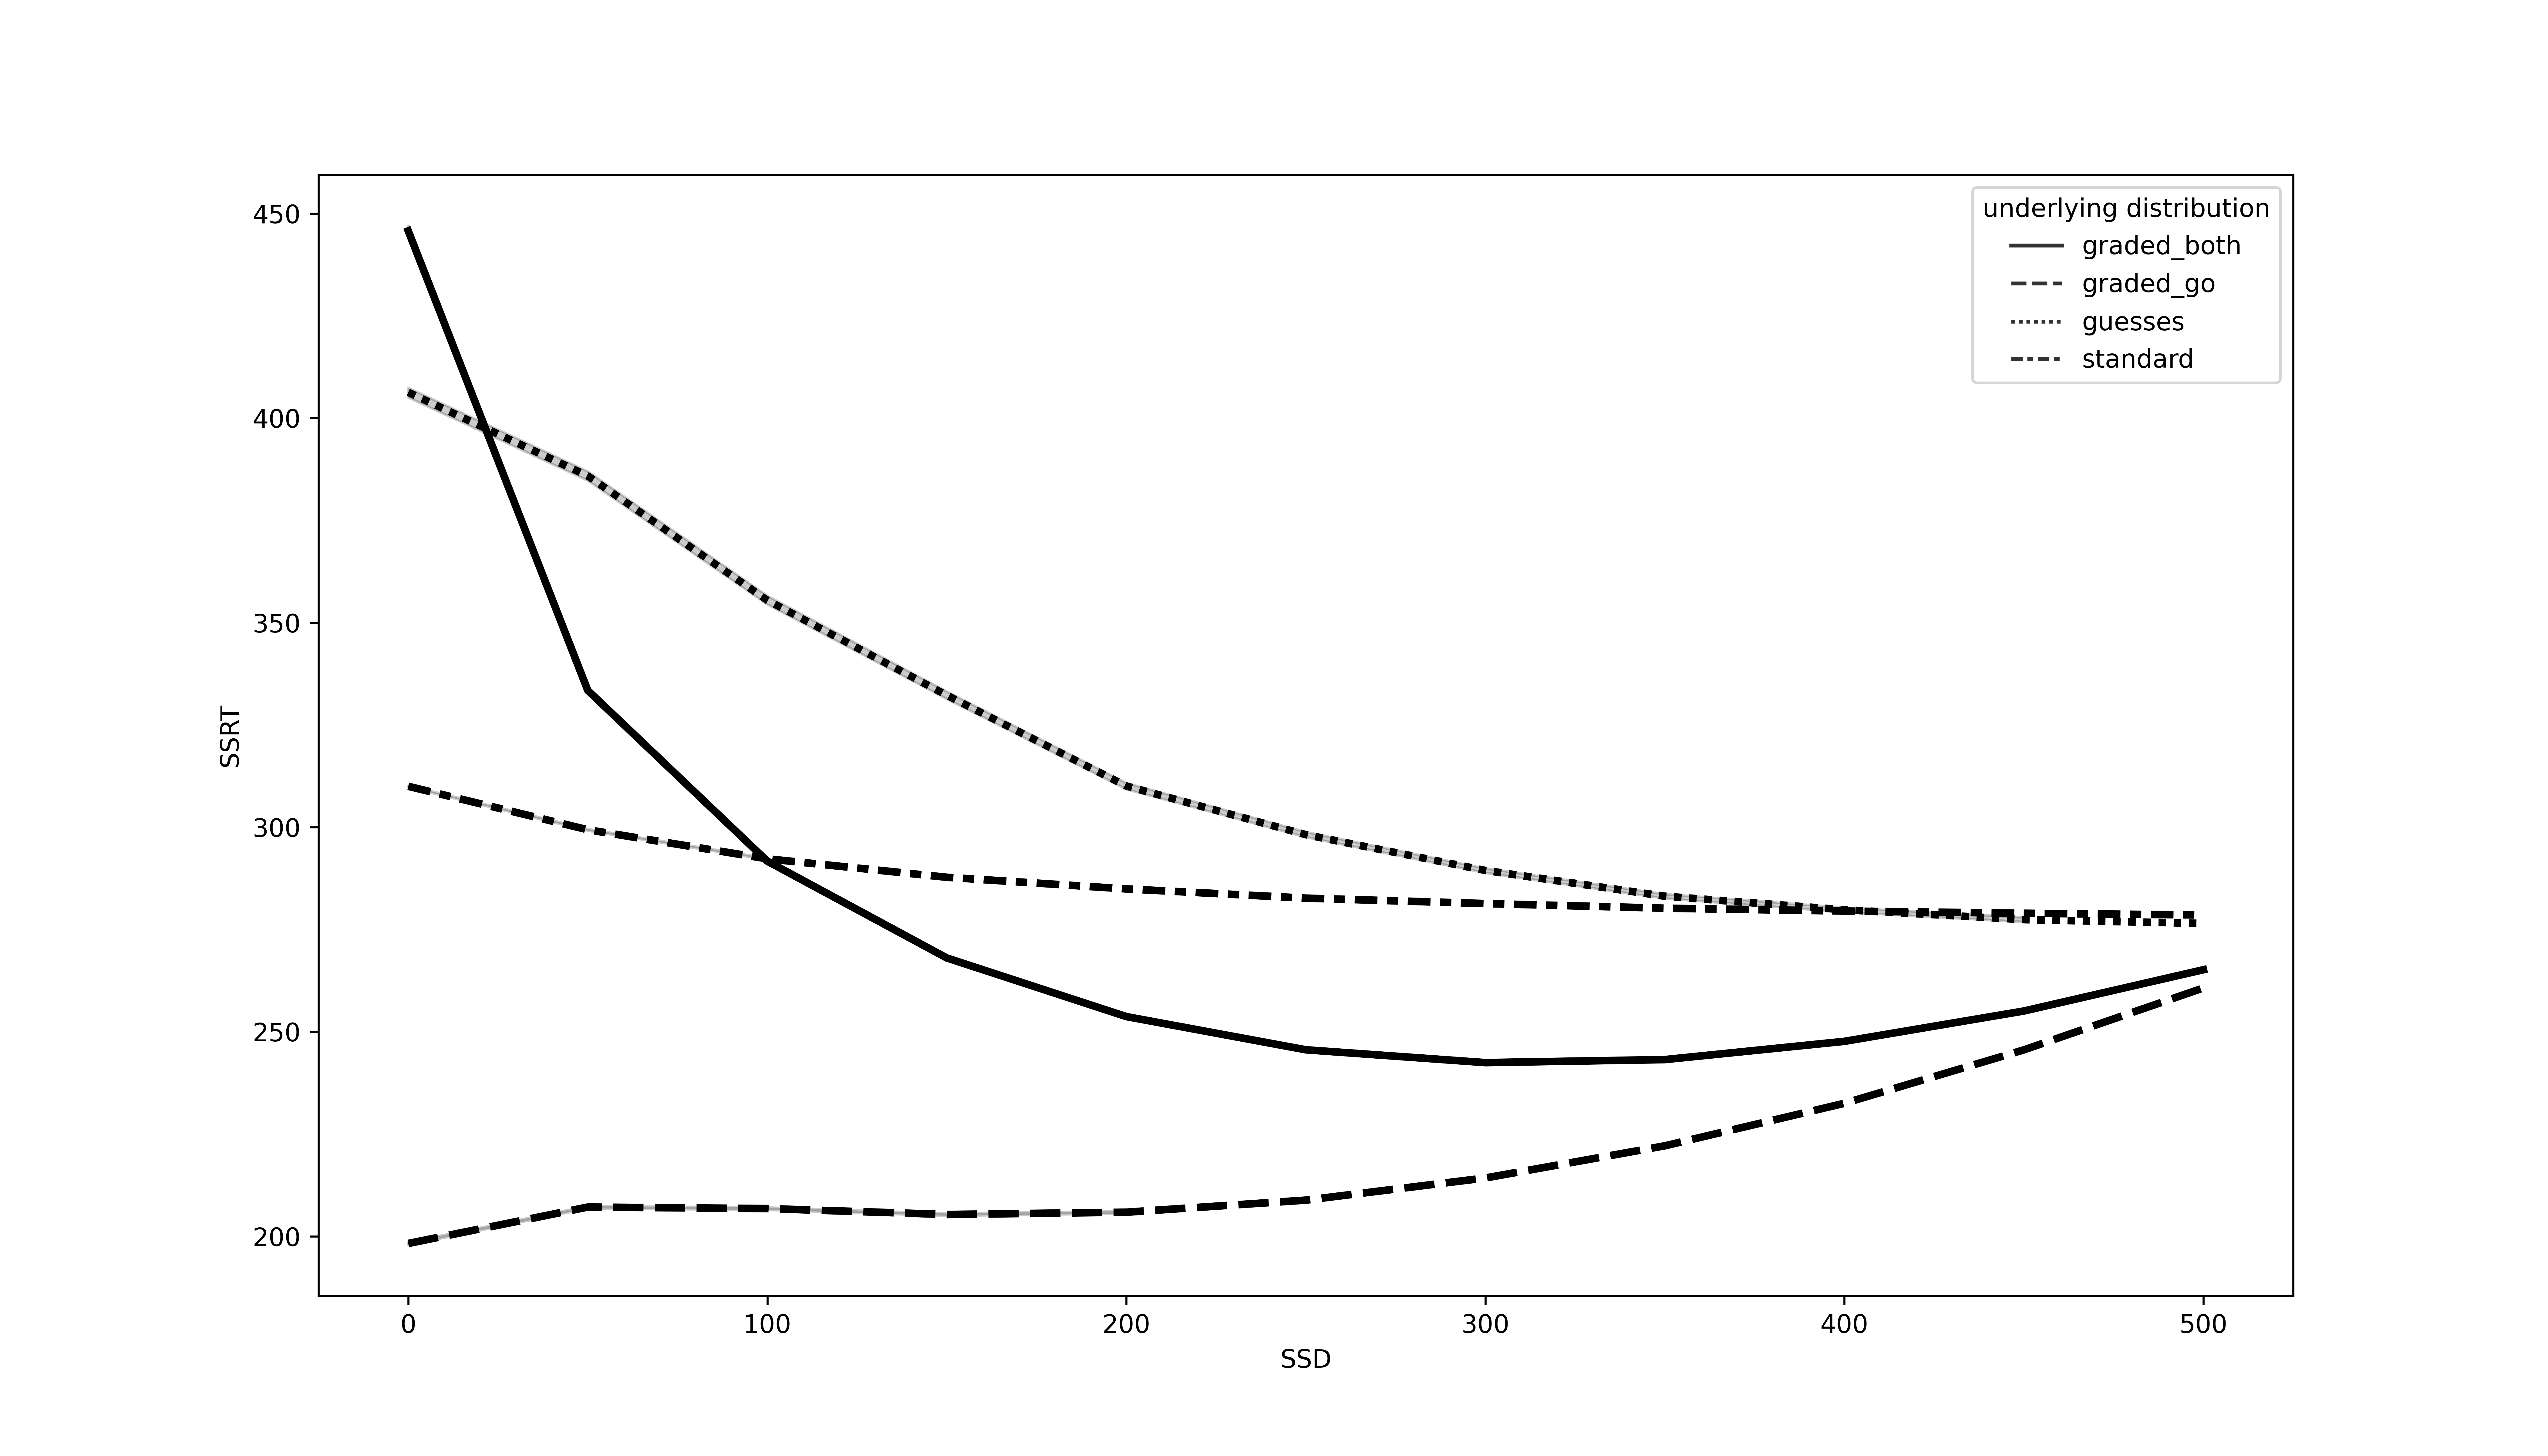

In [3]:
Image('figures/%s/SSRT_by_SSD.png' % suffix)

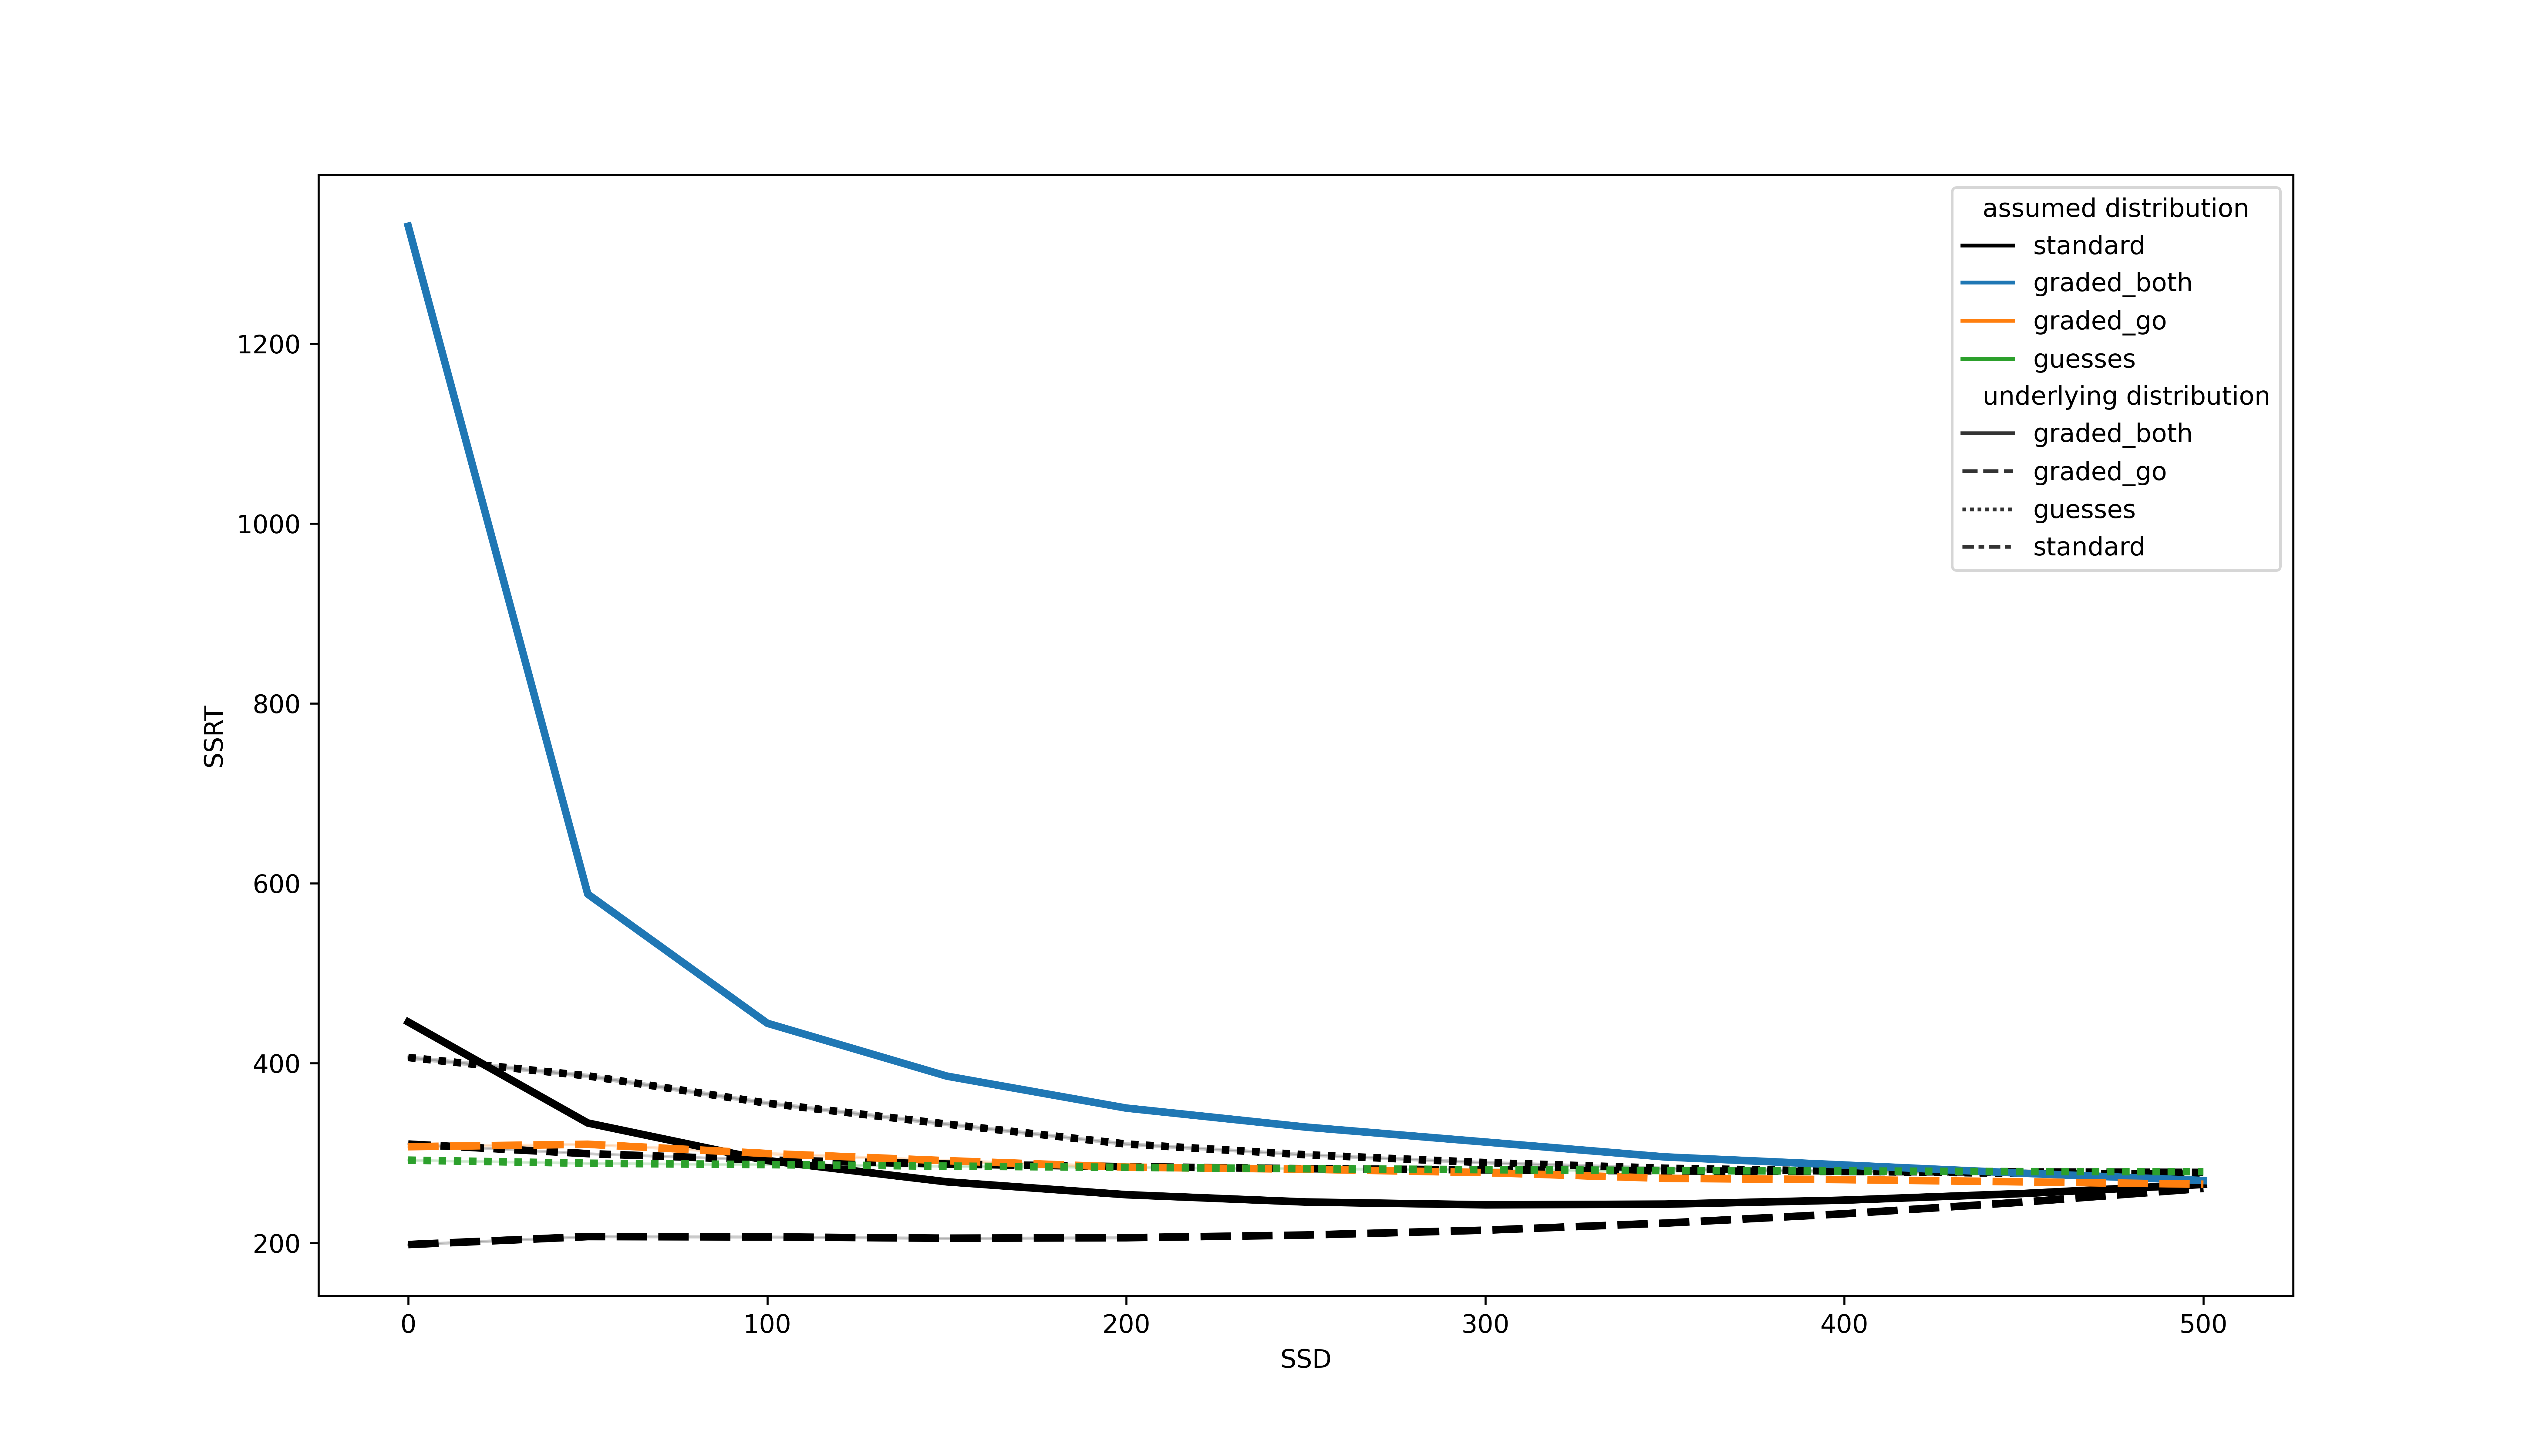

In [4]:
Image('figures/%s/SSRT_by_SSD_supplement.png' % suffix)

# Inhibition Function

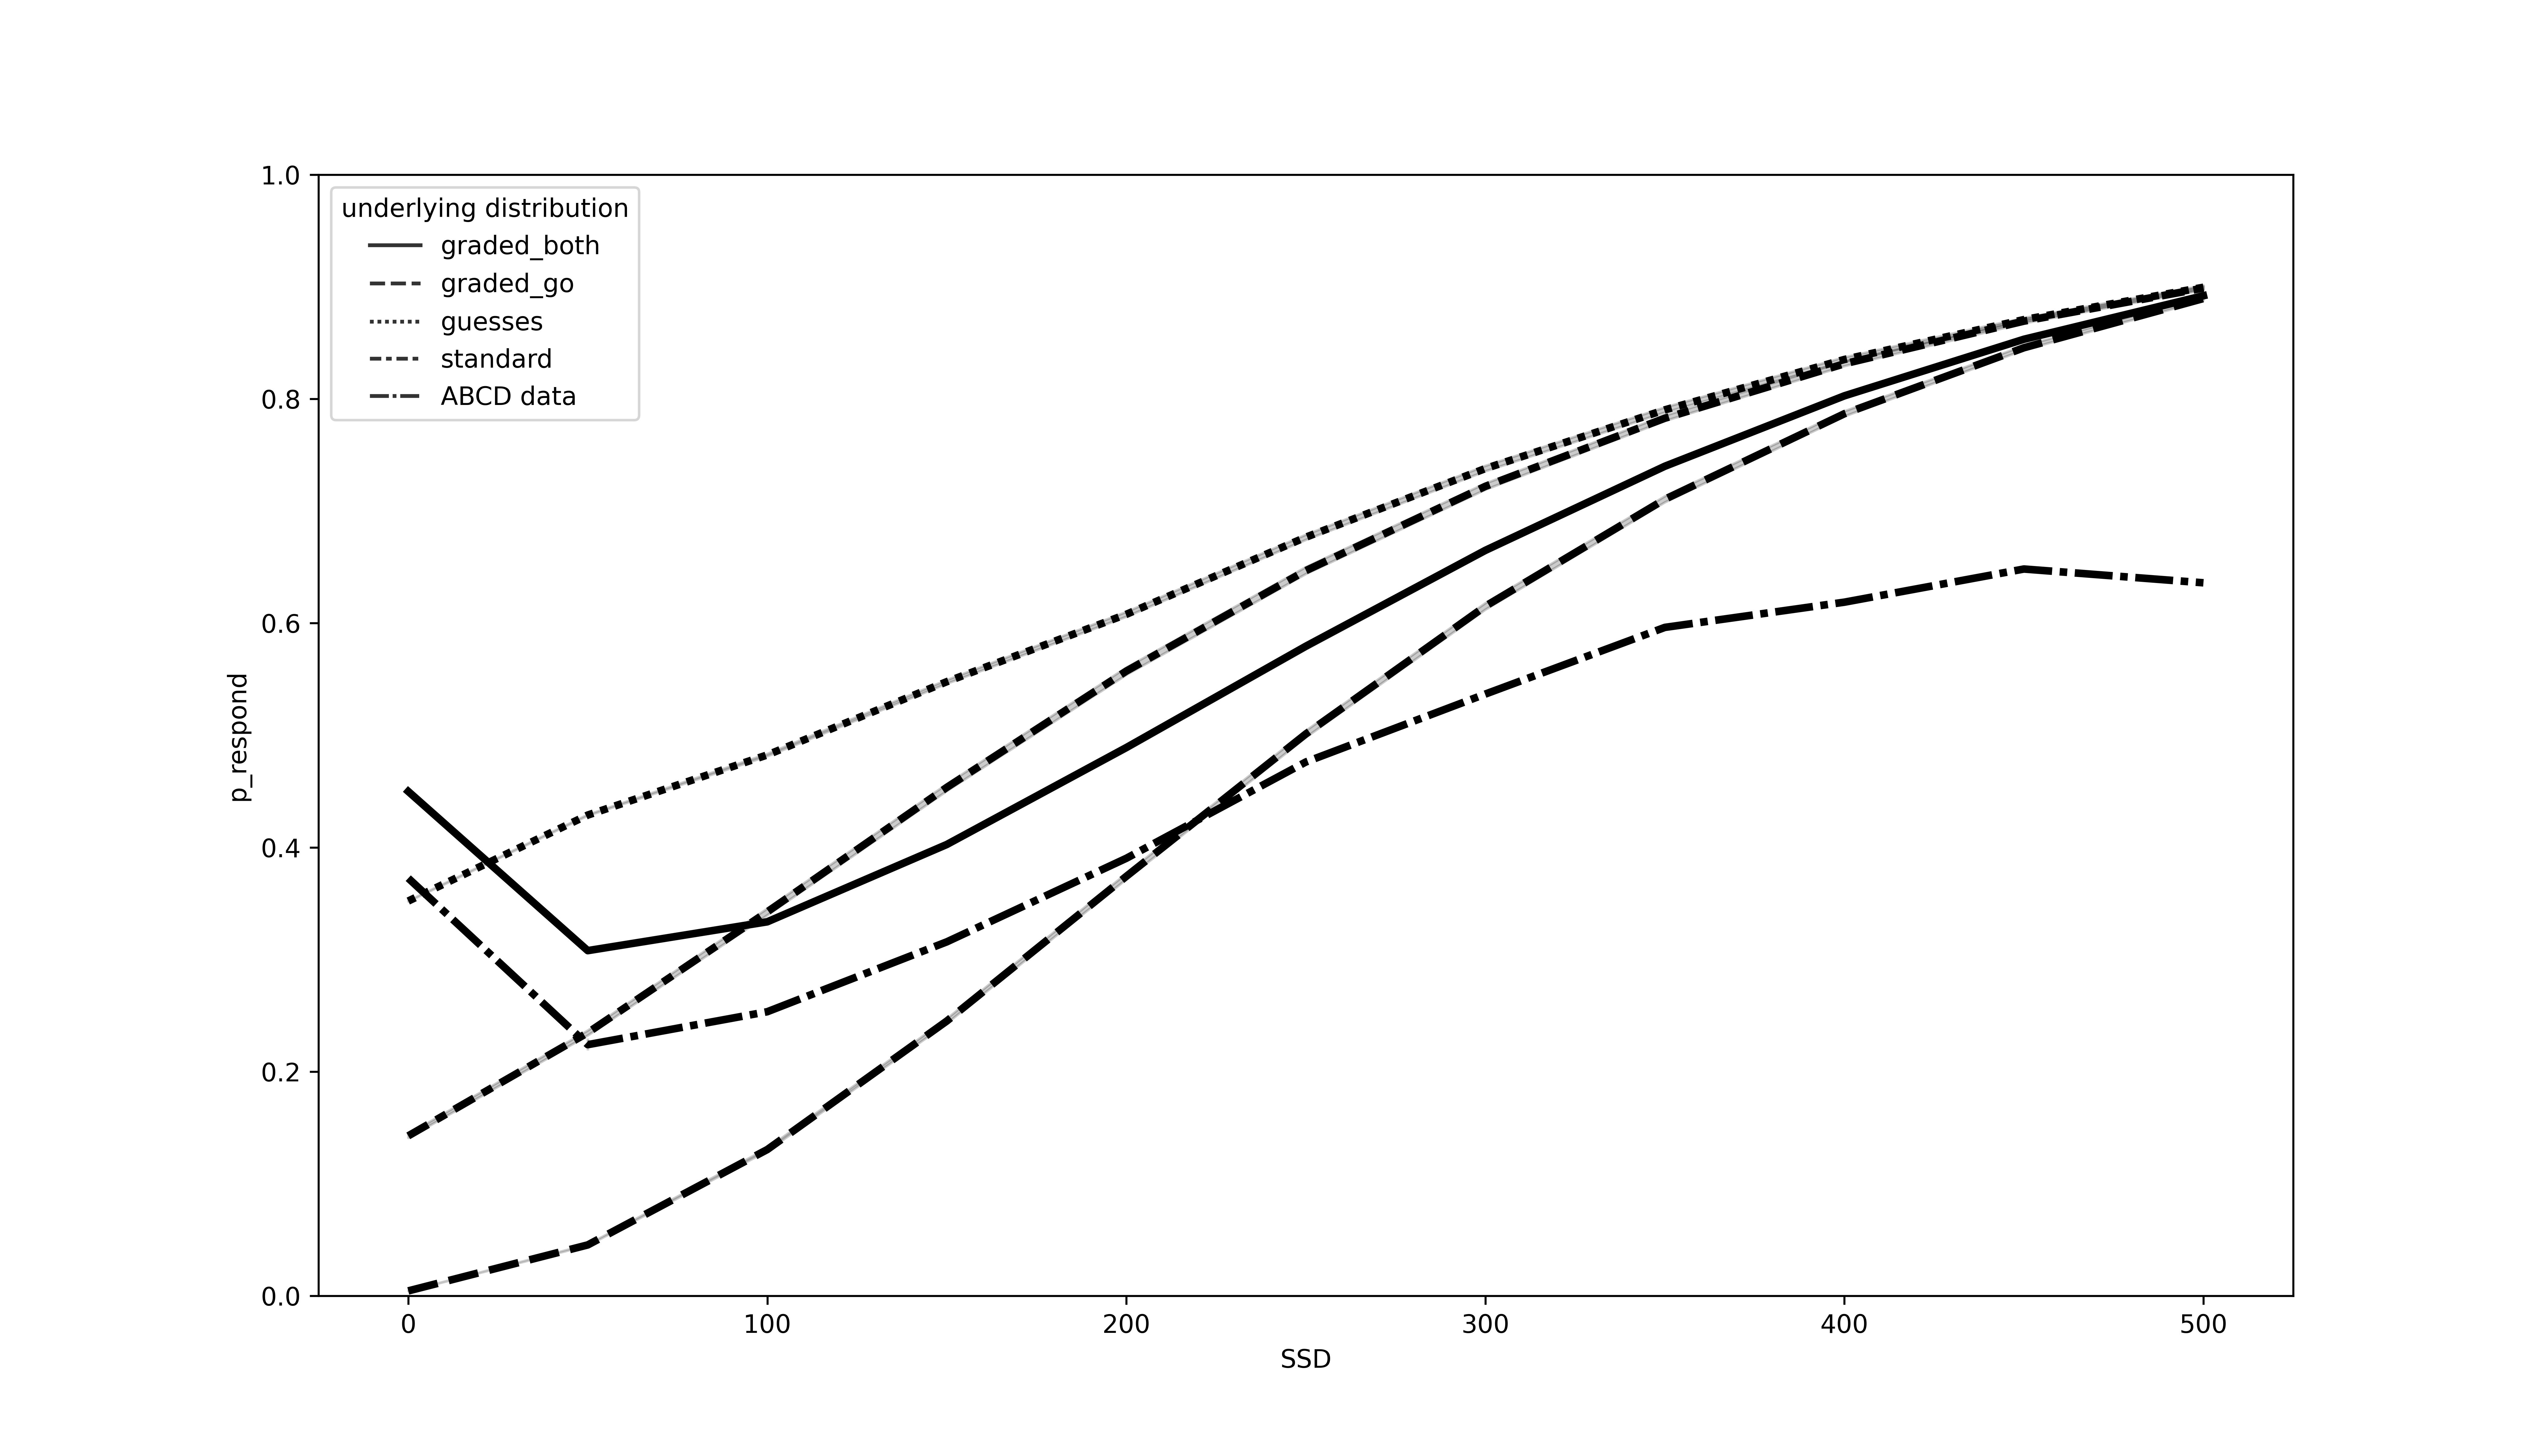

In [5]:
Image('figures/%s/inhibition_function.png' % suffix)

# Individual Differences

In [6]:
def add_identity(axes, *line_args, **line_kwargs):
    identity, = axes.plot([], [], *line_args, **line_kwargs)
    def callback(axes):
        low_x, high_x = axes.get_xlim()
        low_y, high_y = axes.get_ylim()
        low = max(low_x, low_y)
        high = min(high_x, high_y)
        identity.set_data([low, high], [low, high])
    callback(axes)
    axes.callbacks.connect('xlim_changed', callback)
    axes.callbacks.connect('ylim_changed', callback)
    return axes

In [7]:
ssrt_df = pd.read_csv('ssrt_metrics/expected_ssrts_%s.csv' % suffix, index_col=0)

# reformatting - was multiindex
ssrt_df.columns = [ f'gen-{gen}_SSRT-{ssrt}' for gen, ssrt in zip(ssrt_df.loc['underlying distribution', :].values, ssrt_df.columns)]
ssrt_df = ssrt_df.drop(['underlying distribution', 'NARGUID'])

for col in ssrt_df.columns:
    ssrt_df[col] = ssrt_df[col].astype(float)
    
# confirm that no kludge is required - check SSRTscale-0_RTscale-0 for use of kludge
tracking_ssrts = ['gen-graded_both_SSRT-tracking', 'gen-graded_go_SSRT-tracking.1','gen-guesses_SSRT-tracking.2', 'gen-standard_SSRT-tracking.3']
for col in tracking_ssrts:
    assert sum(ssrt_df[col].isnull())==0


In [8]:
# getting expect SSRTs
mus_path = 'abcd_data/assigned_mus_%s.json' % suffix
with open(mus_path, 'r') as f:
    mus_dict = json.load(f)
    
mus_df = pd.DataFrame(mus_dict).T

In [9]:
mus_df.head()

goRT        go        SSRT      stop
003RTV85  678.847492  0.159021  305.691740  0.391096
007W6H7B  457.038672  0.245677  295.696698  0.407006
00CY2MDM  523.996572  0.210972  303.123996  0.395063
00HEV6HB  676.134241  0.159710  296.196275  0.406180
00J52GPG  529.648552  0.208486  302.394802  0.396205

In [10]:
monster_df = pd.concat([mus_df.add_prefix('assigned_'), ssrt_df], 1, sort=True)
monster_df.columns = [col.split('.')[0] for col in monster_df.columns]
monster_df = monster_df.loc[monster_df['gen-standard_SSRT-fixed'].notnull()]

In [11]:
monster_df.shape

(8207, 28)

In [12]:
def make_plot_square(ax):
    lowx, highx = ax.get_xlim()
    lowy, highy = ax.get_ylim()
    low = min(lowx, lowy)
    high = max(highx, highy)
    ax.set_xlim((low, high))
    ax.set_ylim((low, high))
    return ax

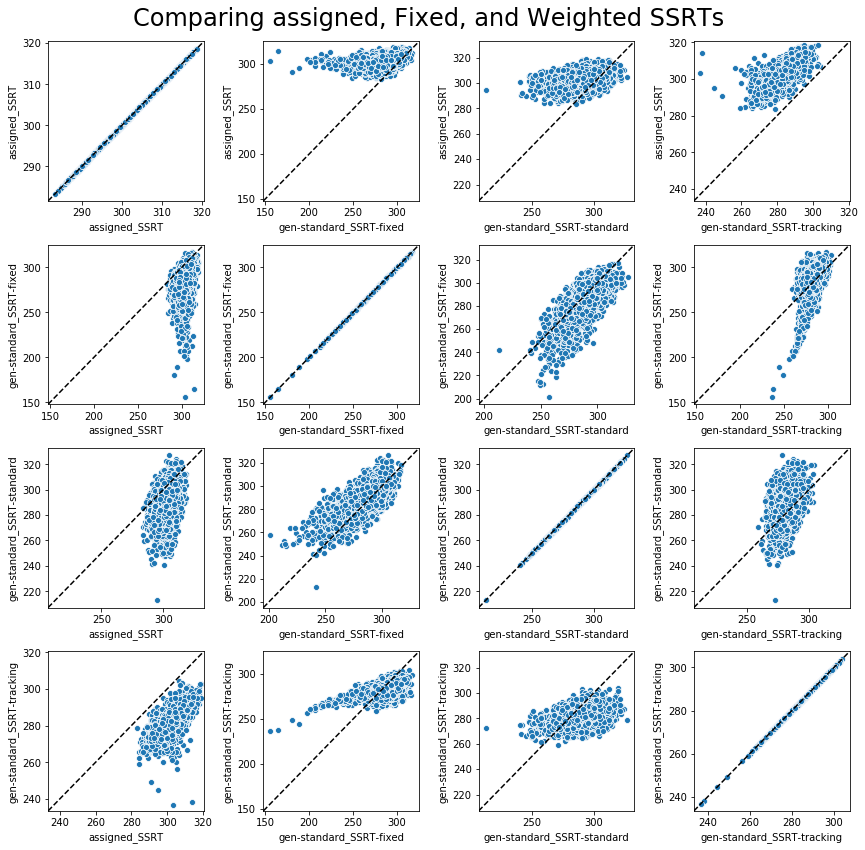

In [13]:
fig, axes = plt.subplots(4, 4, figsize=(12,12))

columns = ['assigned_SSRT', 'gen-standard_SSRT-fixed', 'gen-standard_SSRT-standard', 'gen-standard_SSRT-tracking']
for idx,coli in enumerate(columns):
    for jdx, colj in enumerate(columns):
        ax = sns.scatterplot(x=colj, y=coli, data=monster_df, ax=axes[idx, jdx])
        ax = make_plot_square(ax)
        _ = add_identity(ax, color='k', ls='--')
_ = fig.suptitle('Comparing assigned, Fixed, and Weighted SSRTs', fontsize=24)
fig.tight_layout()
fig.subplots_adjust(top=0.94)

In [14]:
monster_df[columns].corr(method='spearman')

assigned_SSRT  gen-standard_SSRT-fixed  \
assigned_SSRT                    1.000000                 0.352552   
gen-standard_SSRT-fixed          0.352552                 1.000000   
gen-standard_SSRT-standard       0.400528                 0.686262   
gen-standard_SSRT-tracking       0.725644                 0.394766   

                            gen-standard_SSRT-standard  \
assigned_SSRT                                 0.400528   
gen-standard_SSRT-fixed                       0.686262   
gen-standard_SSRT-standard                    1.000000   
gen-standard_SSRT-tracking                    0.380681   

                            gen-standard_SSRT-tracking  
assigned_SSRT                                 0.725644  
gen-standard_SSRT-fixed                       0.394766  
gen-standard_SSRT-standard                    0.380681  
gen-standard_SSRT-tracking                    1.000000

# Comparing Fixed SSRTs

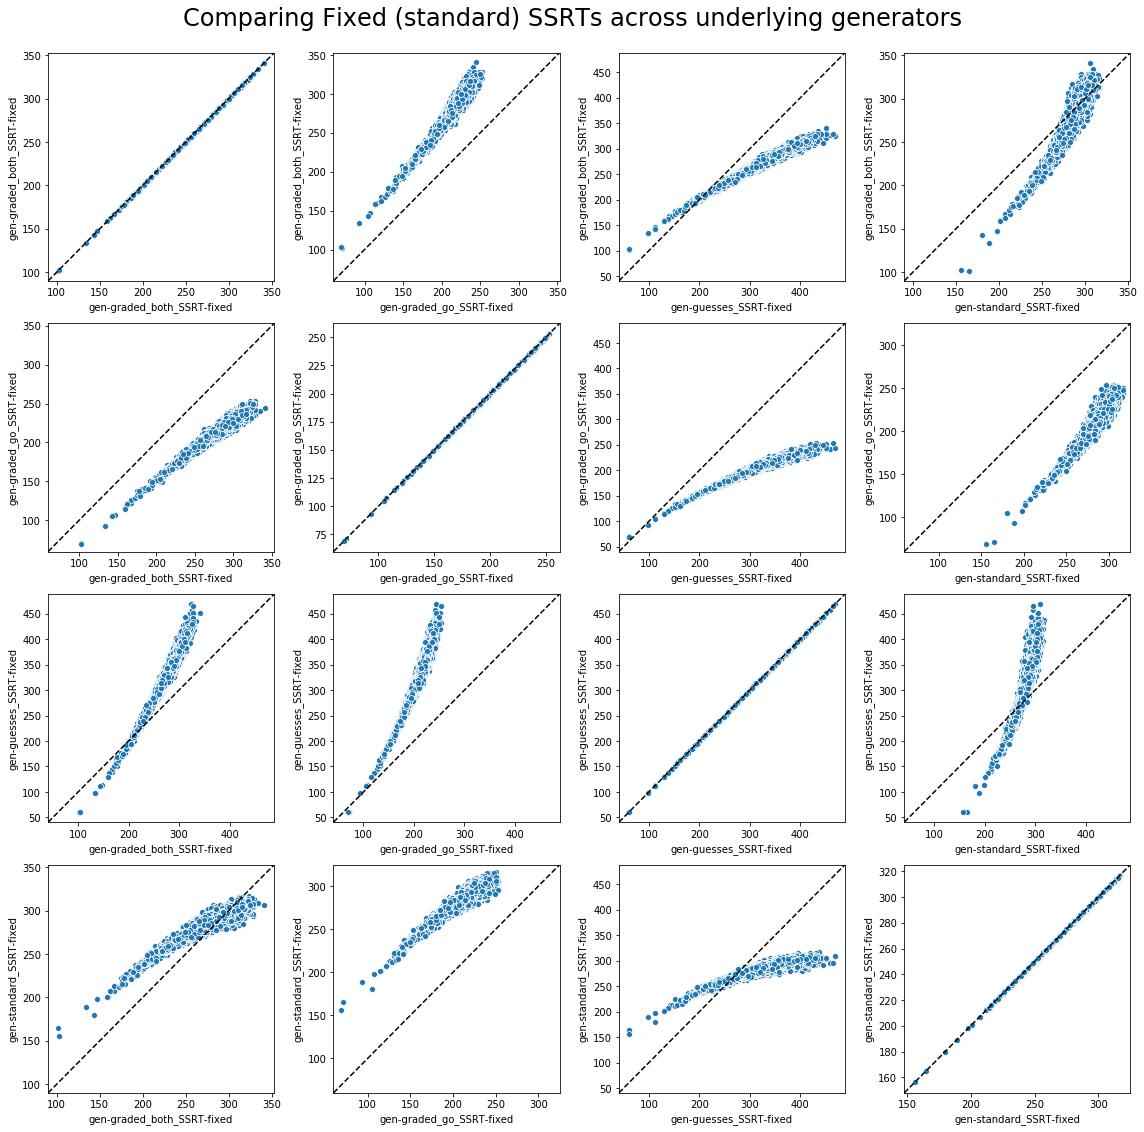

In [15]:
curr_df = monster_df.filter(regex='fixed')

fig, axes = plt.subplots(4, 4, figsize=(16,16))

for idx,coli in enumerate(curr_df.columns):
    for jdx, colj in enumerate(curr_df.columns):
        ax = sns.scatterplot(x=colj, y=coli, data=curr_df, ax=axes[idx, jdx])
        ax = make_plot_square(ax)
        _ = add_identity(ax, color='k', ls='--')
_ = fig.suptitle('Comparing Fixed (standard) SSRTs across underlying generators', fontsize=24)
fig.tight_layout()
fig.subplots_adjust(top=0.94)

In [16]:
curr_df.corr(method='spearman')

gen-graded_both_SSRT-fixed  \
gen-graded_both_SSRT-fixed                    1.000000   
gen-graded_go_SSRT-fixed                      0.961398   
gen-guesses_SSRT-fixed                        0.975852   
gen-standard_SSRT-fixed                       0.892707   

                            gen-graded_go_SSRT-fixed  gen-guesses_SSRT-fixed  \
gen-graded_both_SSRT-fixed                  0.961398                0.975852   
gen-graded_go_SSRT-fixed                    1.000000                0.968253   
gen-guesses_SSRT-fixed                      0.968253                1.000000   
gen-standard_SSRT-fixed                     0.887390                0.879659   

                            gen-standard_SSRT-fixed  
gen-graded_both_SSRT-fixed                 0.892707  
gen-graded_go_SSRT-fixed                   0.887390  
gen-guesses_SSRT-fixed                     0.879659  
gen-standard_SSRT-fixed                    1.000000

## (not rescaling the axes to get a closer look)

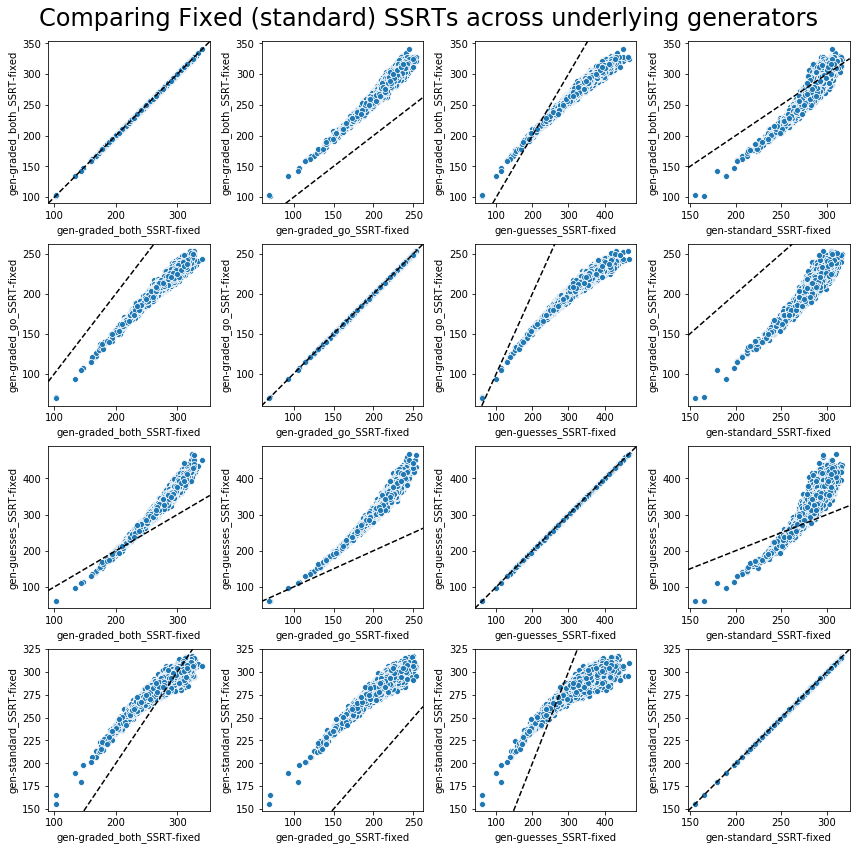

In [17]:
curr_df = monster_df.filter(regex='fixed')
fig, axes = plt.subplots(4, 4, figsize=(12,12))

for idx,coli in enumerate(curr_df.columns):
    for jdx, colj in enumerate(curr_df.columns):
        ax = sns.scatterplot(x=colj, y=coli, data=curr_df, ax=axes[idx, jdx])
#         ax = make_plot_square(ax)
        _ = add_identity(ax, color='k', ls='--')
_ = fig.suptitle('Comparing Fixed (standard) SSRTs across underlying generators', fontsize=24)
fig.tight_layout()
fig.subplots_adjust(top=0.94)

# Weighted SSRTs (from randomly assigned SSD distributions)

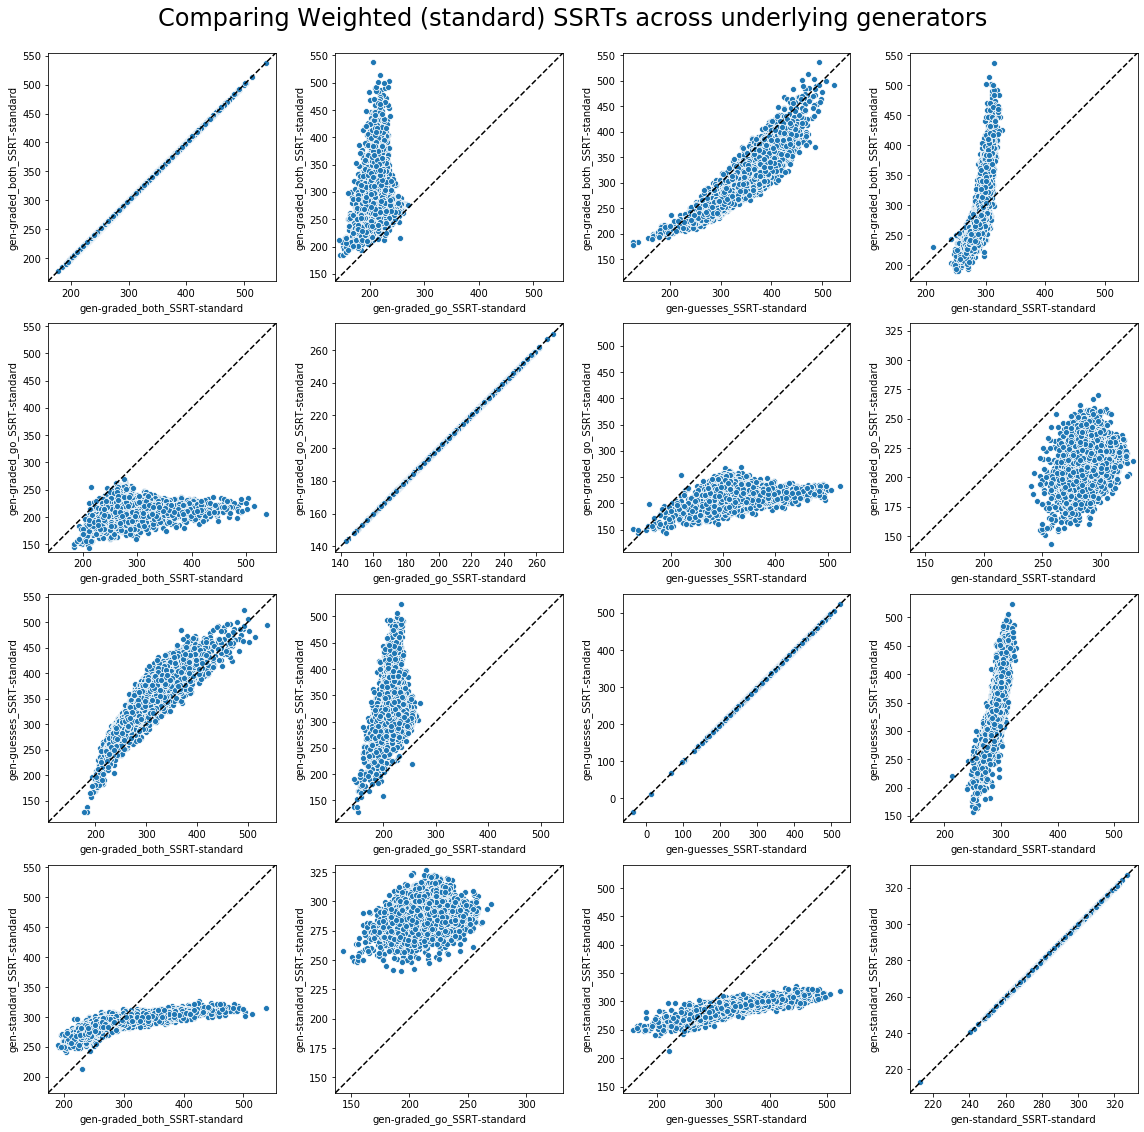

In [18]:
curr_df = monster_df.filter(regex='SSRT-standard')

fig, axes = plt.subplots(4, 4, figsize=(16,16))

for idx,coli in enumerate(curr_df.columns):
    for jdx, colj in enumerate(curr_df.columns):
        ax = sns.scatterplot(x=colj, y=coli, data=curr_df, ax=axes[idx, jdx])
        ax = make_plot_square(ax)
        _ = add_identity(ax, color='k', ls='--')
_ = fig.suptitle('Comparing Weighted (standard) SSRTs across underlying generators', fontsize=24)
fig.tight_layout()
fig.subplots_adjust(top=0.94)

In [19]:
curr_df.corr(method='spearman')

gen-graded_both_SSRT-standard  \
gen-graded_both_SSRT-standard                       1.000000   
gen-graded_go_SSRT-standard                         0.101053   
gen-guesses_SSRT-standard                           0.918037   
gen-standard_SSRT-standard                          0.820038   

                               gen-graded_go_SSRT-standard  \
gen-graded_both_SSRT-standard                     0.101053   
gen-graded_go_SSRT-standard                       1.000000   
gen-guesses_SSRT-standard                         0.213575   
gen-standard_SSRT-standard                        0.177758   

                               gen-guesses_SSRT-standard  \
gen-graded_both_SSRT-standard                   0.918037   
gen-graded_go_SSRT-standard                     0.213575   
gen-guesses_SSRT-standard                       1.000000   
gen-standard_SSRT-standard                      0.812880   

                               gen-standard_SSRT-standard  
gen-graded_both_SSRT-standard                    0.820038  
gen-graded_go_SSRT-standard                      0.177758  
gen-guesses_SSRT-standard                        0.812880  
gen-standard_SSRT-standard                       1.000000

## not rescaling axis to get a closer look

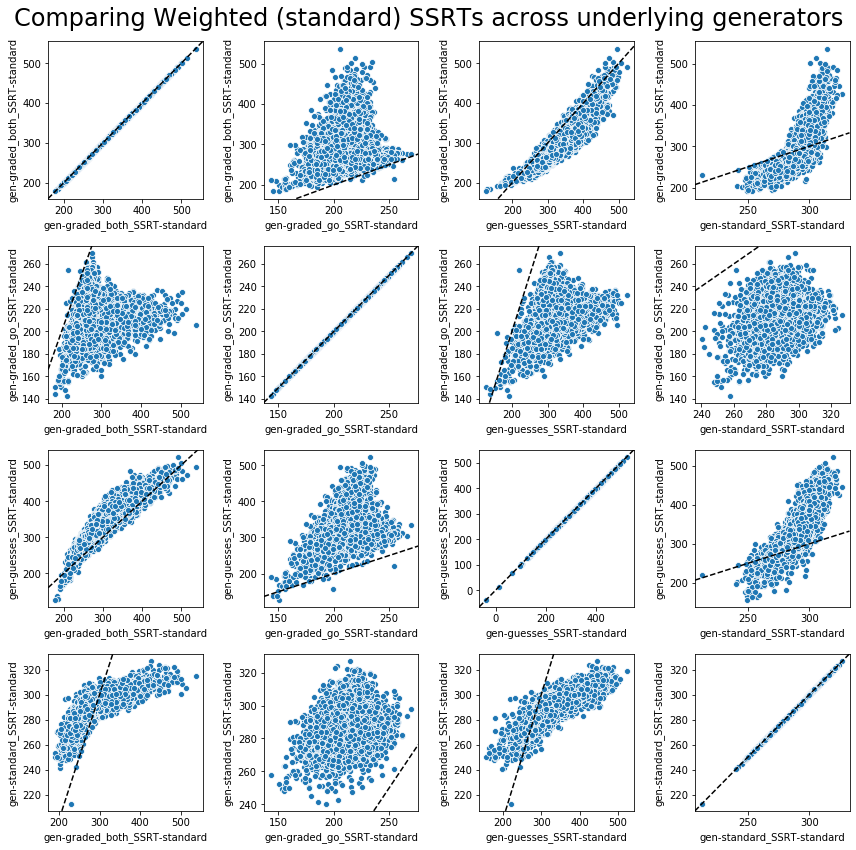

In [20]:
fig, axes = plt.subplots(4, 4, figsize=(12,12))

for idx,coli in enumerate(curr_df.columns):
    for jdx, colj in enumerate(curr_df.columns):
        ax = sns.scatterplot(x=colj, y=coli, data=curr_df, ax=axes[idx, jdx])
#         ax = make_plot_square(ax)
        _ = add_identity(ax, color='k', ls='--')
_ = fig.suptitle('Comparing Weighted (standard) SSRTs across underlying generators', fontsize=24)
fig.tight_layout()
fig.subplots_adjust(top=0.94)

# Tracking-based SSRTs

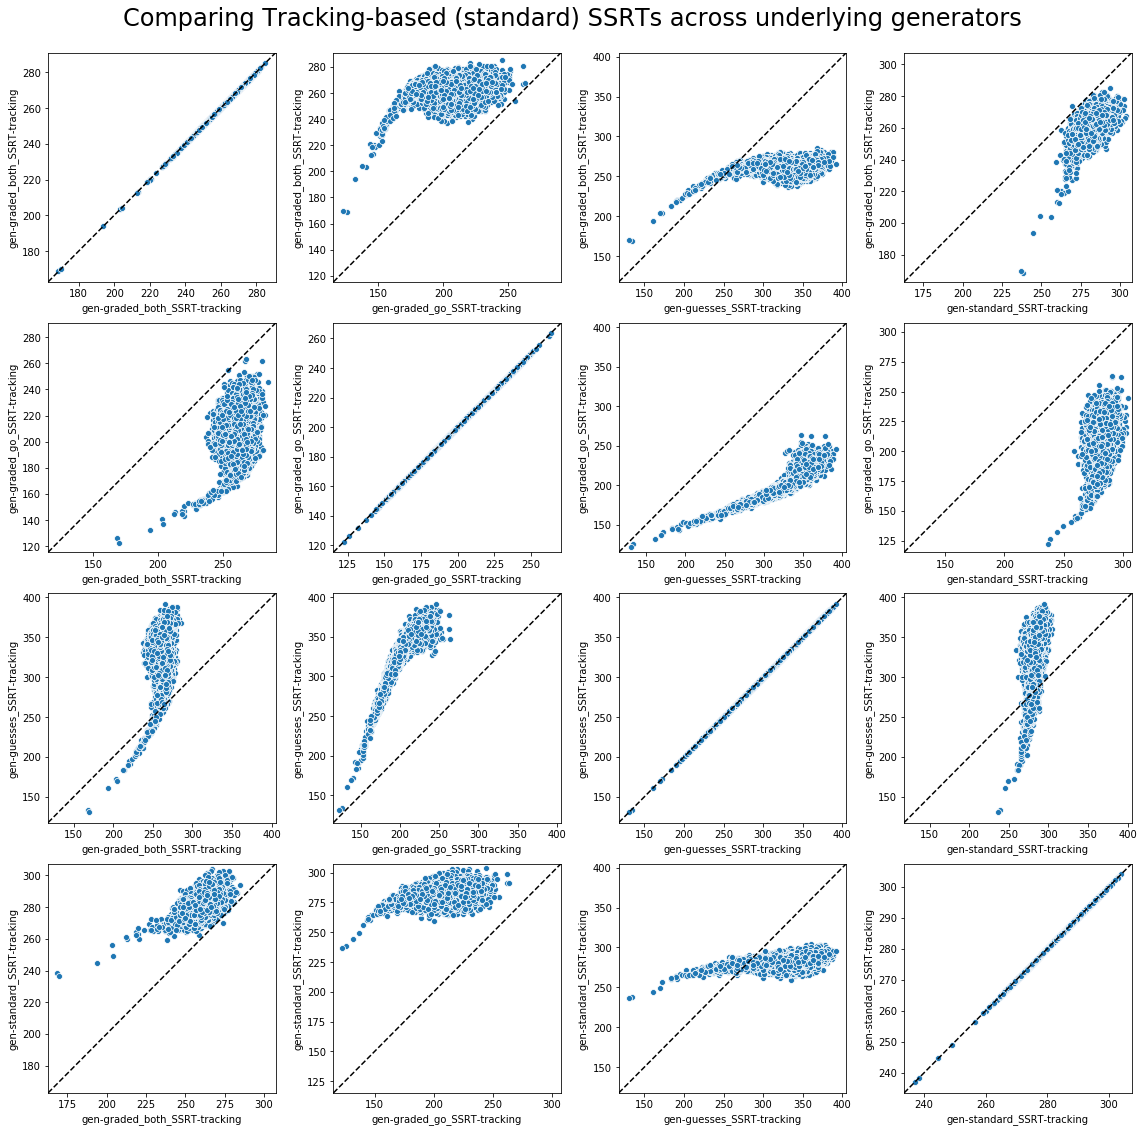

In [21]:
curr_df = monster_df.filter(regex='SSRT-tracking')

fig, axes = plt.subplots(4, 4, figsize=(16,16))

for idx,coli in enumerate(curr_df.columns):
    for jdx, colj in enumerate(curr_df.columns):
        ax = sns.scatterplot(x=colj, y=coli, data=curr_df, ax=axes[idx, jdx])
        ax = make_plot_square(ax)
        _ = add_identity(ax, color='k', ls='--')
_ = fig.suptitle('Comparing Tracking-based (standard) SSRTs across underlying generators', fontsize=24)
fig.tight_layout()
fig.subplots_adjust(top=0.94)

In [22]:
curr_df.corr(method='spearman')

gen-graded_both_SSRT-tracking  \
gen-graded_both_SSRT-tracking                       1.000000   
gen-graded_go_SSRT-tracking                         0.041791   
gen-guesses_SSRT-tracking                           0.099967   
gen-standard_SSRT-tracking                          0.553595   

                               gen-graded_go_SSRT-tracking  \
gen-graded_both_SSRT-tracking                     0.041791   
gen-graded_go_SSRT-tracking                       1.000000   
gen-guesses_SSRT-tracking                         0.925073   
gen-standard_SSRT-tracking                        0.269586   

                               gen-guesses_SSRT-tracking  \
gen-graded_both_SSRT-tracking                   0.099967   
gen-graded_go_SSRT-tracking                     0.925073   
gen-guesses_SSRT-tracking                       1.000000   
gen-standard_SSRT-tracking                      0.342063   

                               gen-standard_SSRT-tracking  
gen-graded_both_SSRT-tracking                    0.553595  
gen-graded_go_SSRT-tracking                      0.269586  
gen-guesses_SSRT-tracking                        0.342063  
gen-standard_SSRT-tracking                       1.000000

## not rescaling axes

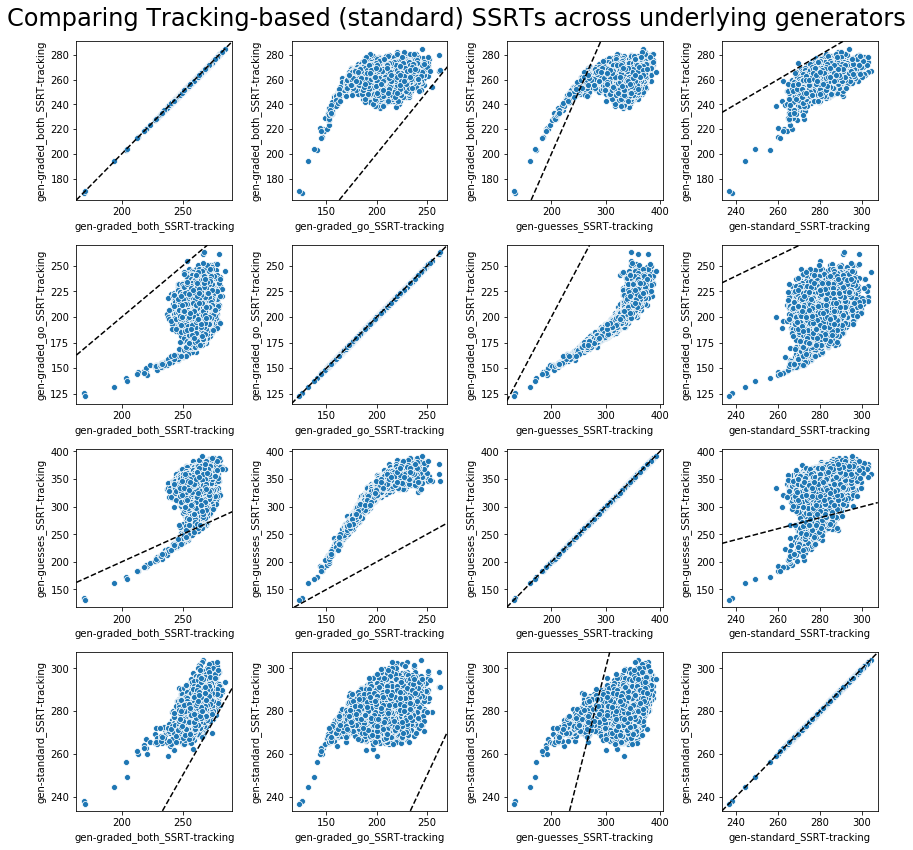

In [23]:
fig, axes = plt.subplots(4, 4, figsize=(12,12))

for idx,coli in enumerate(curr_df.columns):
    for jdx, colj in enumerate(curr_df.columns):
        ax = sns.scatterplot(x=colj, y=coli, data=curr_df, ax=axes[idx, jdx])
#         ax = make_plot_square(ax)
        _ = add_identity(ax, color='k', ls='--')
_ = fig.suptitle('Comparing Tracking-based (standard) SSRTs across underlying generators', fontsize=24)
fig.tight_layout()
fig.subplots_adjust(top=0.94)

In [24]:
main_cols = ['assigned_SSRT',
             'gen-graded_both_SSRT-standard',
             'gen-graded_go_SSRT-standard',
             'gen-guesses_SSRT-standard',
             'gen-standard_SSRT-standard',
             'gen-graded_both_SSRT-fixed',
             'gen-graded_go_SSRT-fixed',
             'gen-guesses_SSRT-fixed',
             'gen-standard_SSRT-fixed',
             'gen-graded_both_SSRT-tracking',
             'gen-graded_go_SSRT-tracking',
             'gen-guesses_SSRT-tracking',
             'gen-standard_SSRT-tracking']
monster_df[main_cols].describe()

assigned_SSRT  gen-graded_both_SSRT-standard  \
count    8207.000000                    8175.000000   
mean      301.313690                     278.156878   
std         5.044257                      42.433848   
min       283.372821                     178.200000   
25%       297.979516                     251.718001   
50%       301.318490                     266.050000   
75%       304.683298                     292.358333   
max       318.631766                     537.150000   

       gen-graded_go_SSRT-standard  gen-guesses_SSRT-standard  \
count                  8178.000000                8206.000000   
mean                    213.727128                 320.620475   
std                      15.178567                  45.715878   
min                     143.066667                 -36.683333   
25%                     204.537500                 292.923864   
50%                     214.016667                 313.225000   
75%                     223.700000                 344.666667   
max                     269.976190                 523.183333   

       gen-standard_SSRT-standard  gen-graded_both_SSRT-fixed  \
count                 8165.000000                 8207.000000   
mean                   287.381212                  276.512489   
std                     10.307832                   22.640351   
min                    212.833333                  102.000000   
25%                    281.033898                  264.000000   
50%                    287.216667                  280.000000   
75%                    293.900000                  292.000000   
max                    327.050000                  341.000000   

       gen-graded_go_SSRT-fixed  gen-guesses_SSRT-fixed  \
count               8207.000000             8207.000000   
mean                 211.958328              332.987450   
std                   16.937419               43.058394   
min                   69.000000               61.000000   
25%                  203.000000              308.000000   
50%                  214.000000              337.000000   
75%                  223.000000              362.000000   
max                  253.000000              468.000000   

       gen-standard_SSRT-fixed  gen-graded_both_SSRT-tracking  \
count              8207.000000                    8207.000000   
mean                285.196661                     260.550631   
std                  12.543731                       6.978287   
min                 156.000000                     168.630000   
25%                 279.000000                     256.277000   
50%                 287.000000                     260.802000   
75%                 293.000000                     265.142000   
max                 317.000000                     285.022000   

       gen-graded_go_SSRT-tracking  gen-guesses_SSRT-tracking  \
count                  8207.000000                8207.000000   
mean                    205.947702                 334.869246   
std                      16.371771                  27.837660   
min                     122.360000                 130.828000   
25%                     195.592000                 322.256000   
50%                     206.612000                 341.436000   
75%                     217.130000                 353.988000   
max                     263.348000                 391.908000   

       gen-standard_SSRT-tracking  
count                 8207.000000  
mean                   281.457522  
std                      5.779582  
min                    236.864000  
25%                    277.676000  
50%                    281.438000  
75%                    285.267000  
max                    304.038000

In [25]:
ssrt_df.corr(method='spearman')

gen-graded_both_SSRT-standard  \
gen-graded_both_SSRT-standard                          1.000000   
gen-graded_go_SSRT-standard.1                          0.101053   
gen-guesses_SSRT-standard.2                            0.918037   
gen-standard_SSRT-standard.3                           0.820038   
gen-graded_both_SSRT-guesses                           0.139716   
gen-graded_go_SSRT-guesses.1                          -0.790145   
gen-guesses_SSRT-guesses.2                             0.613631   
gen-standard_SSRT-guesses.3                           -0.851510   
gen-graded_both_SSRT-graded_go                         0.677851   
gen-graded_go_SSRT-graded_go.1                         0.426730   
gen-guesses_SSRT-graded_go.2                           0.726086   
gen-standard_SSRT-graded_go.3                          0.434992   
gen-graded_both_SSRT-graded_both                       0.677851   
gen-graded_go_SSRT-graded_both.1                       0.426730   
gen-guesses_SSRT-graded_both.2                         0.726086   
gen-standard_SSRT-graded_both.3                        0.434992   
gen-graded_both_SSRT-fixed                             0.575483   
gen-graded_go_SSRT-fixed.1                             0.557799   
gen-guesses_SSRT-fixed.2                               0.561153   
gen-standard_SSRT-fixed.3                              0.540092   
gen-graded_both_SSRT-tracking                          0.047522   
gen-graded_go_SSRT-tracking.1                          0.560018   
gen-guesses_SSRT-tracking.2                            0.547964   
gen-standard_SSRT-tracking.3                           0.176638   

                                  gen-graded_go_SSRT-standard.1  \
gen-graded_both_SSRT-standard                          0.101053   
gen-graded_go_SSRT-standard.1                          1.000000   
gen-guesses_SSRT-standard.2                            0.213575   
gen-standard_SSRT-standard.3                           0.177758   
gen-graded_both_SSRT-guesses                          -0.219034   
gen-graded_go_SSRT-guesses.1                           0.415055   
gen-guesses_SSRT-guesses.2                             0.263276   
gen-standard_SSRT-guesses.3                           -0.112121   
gen-graded_both_SSRT-graded_go                        -0.478359   
gen-graded_go_SSRT-graded_go.1                        -0.178466   
gen-guesses_SSRT-graded_go.2                          -0.409974   
gen-standard_SSRT-graded_go.3                         -0.663384   
gen-graded_both_SSRT-graded_both                      -0.478359   
gen-graded_go_SSRT-graded_both.1                      -0.178466   
gen-guesses_SSRT-graded_both.2                        -0.409974   
gen-standard_SSRT-graded_both.3                       -0.663384   
gen-graded_both_SSRT-fixed                             0.723282   
gen-graded_go_SSRT-fixed.1                             0.746515   
gen-guesses_SSRT-fixed.2                               0.725692   
gen-standard_SSRT-fixed.3                              0.681641   
gen-graded_both_SSRT-tracking                          0.071151   
gen-graded_go_SSRT-tracking.1                          0.715343   
gen-guesses_SSRT-tracking.2                            0.705169   
gen-standard_SSRT-tracking.3                           0.247106   

                                  gen-guesses_SSRT-standard.2  \
gen-graded_both_SSRT-standard                        0.918037   
gen-graded_go_SSRT-standard.1                        0.213575   
gen-guesses_SSRT-standard.2                          1.000000   
gen-standard_SSRT-standard.3                         0.812880   
gen-graded_both_SSRT-guesses                        -0.153535   
gen-graded_go_SSRT-guesses.1                        -0.746371   
gen-guesses_SSRT-guesses.2                           0.676874   
gen-standard_SSRT-guesses.3                         -0.928846   
gen-graded_both_SSRT-graded_go                       0.553354   
gen-graded_go_SSRT-graded_go.1  

## How many subs survived (i.e. didn't have non-null SSRTs)

This can occur during the weighted method if one of their SSD-specific SSRTs is null. Not sure if you want me to fix.

In [26]:
monster_df.columns

options = ['standard', 'guesses', 'graded_go', 'graded_both']

for gen_str in options:
    for ssrt_str in options:
        col = 'gen-%s_SSRT-%s' % (gen_str, ssrt_str)
        print(col, len(monster_df.loc[monster_df[col].notnull()]))

gen-standard_SSRT-standard 8165
gen-standard_SSRT-guesses 8165
gen-standard_SSRT-graded_go 8165
gen-standard_SSRT-graded_both 8165
gen-guesses_SSRT-standard 8206
gen-guesses_SSRT-guesses 8206
gen-guesses_SSRT-graded_go 8206
gen-guesses_SSRT-graded_both 8206
gen-graded_go_SSRT-standard 8178
gen-graded_go_SSRT-guesses 8178
gen-graded_go_SSRT-graded_go 8178
gen-graded_go_SSRT-graded_both 8178
gen-graded_both_SSRT-standard 8175
gen-graded_both_SSRT-guesses 8175
gen-graded_both_SSRT-graded_go 8175
gen-graded_both_SSRT-graded_both 8175


In [27]:
ssrt_df.filter(regex='SSRT-tracking').describe()

gen-graded_both_SSRT-tracking  gen-graded_go_SSRT-tracking.1  \
count                    8207.000000                    8207.000000   
mean                      260.550631                     205.947702   
std                         6.978287                      16.371771   
min                       168.630000                     122.360000   
25%                       256.277000                     195.592000   
50%                       260.802000                     206.612000   
75%                       265.142000                     217.130000   
max                       285.022000                     263.348000   

       gen-guesses_SSRT-tracking.2  gen-standard_SSRT-tracking.3  
count                  8207.000000                   8207.000000  
mean                    334.869246                    281.457522  
std                      27.837660                      5.779582  
min                     130.828000                    236.864000  
25%                     322.256000                    277.676000  
50%                     341.436000                    281.438000  
75%                     353.988000                    285.267000  
max                     391.908000                    304.038000